In [1]:
import pandas as pd
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import one_hot, resize_to_ori_calMRE, resize_to_ori
from Kmeans_sampling import Kmeans
from itertools import permutations
import scipy.stats
from scipy import stats

In [2]:
 def calc_distance_emd_hist(x1, x2, m):
        np.set_printoptions(precision=2)
        # x1, x2 are two election histograms (normalized)
        # m is number of alternatives

        fact_m = len(x1)

        # find mapping
        alts = tuple(range(m))
        perms = list(permutations(alts))

        emd = np.inf

        for i, p1 in enumerate(perms):

            new_x2 = []
            for p2 in perms:

                new_p2 = []
                for j in p2:
                    new_p2.append(p1[j])
                new_p2 = tuple(new_p2)
                idx = perms.index(new_p2)

                new_x2.append(x2[idx])
            new_x2 = np.array(new_x2)

            emd = np.min((emd, np.linalg.norm(x1 - new_x2)))

        return emd

In [3]:
folder = 'election_GAN/'
gen_results = 'generated_results/'

model = 'model_'+'.ckpt'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

# save ckpt
saver_path = os.path.join(folder, model)

# read ckpt
restore_path = os.path.join(folder)

# save generated data
generated_path = os.path.join(folder + gen_results)

In [4]:
img_width = 30
img_height = 24

data_alt3_all = pd.read_csv('./data/netflix_data_3alt_resize.csv')
data_alt3 = data_alt3_all.iloc[:1000,1:].values
data_alt3_val = data_alt3_all.iloc[1000:2000,1:].values
data_alt3_rest = data_alt3_all.iloc[2000:,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
data_alt3_val = data_alt3_val.reshape([-1, img_height, img_width])
data_alt3_rest = data_alt3_rest.reshape([-1, img_height, img_width])
print(data_alt3.shape)
print(data_alt3_val.shape)
print(data_alt3_rest.shape)

(1000, 24, 30)
(1000, 24, 30)
(3001, 24, 30)


In [5]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(3)

data_alt3_ori = resize_to_ori_calMRE(data_alt3, img_size, img_width, img_height, ori_size)
data_alt3_val_ori = resize_to_ori_calMRE(data_alt3_val, img_size, img_width, img_height, ori_size)
data_alt3_rest_ori = resize_to_ori_calMRE(data_alt3_rest, img_size, img_width, img_height, ori_size)

print(data_alt3_ori.shape)
print(data_alt3_val_ori.shape)
print(data_alt3_rest_ori.shape)

(1000, 6)
(1000, 6)
(3001, 6)


In [6]:
def plot_distribution(x, x_axis_len):
    delta_real_sort = np.sort(x)

    delta_real_sort_count = []
    delta_real_sort_subsample = []
    x_axis = []

    for i in range(0, x_axis_len, 1):
        x_axis.append(i/100)
        iter_ = i/100
        count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
        count_ = np.array(count).reshape([-1]).shape[0]
        delta_real_sort_count.append(count_)

    delta_real_sort_count = np.array(delta_real_sort_count)
    print(len(delta_real_sort_count))

    plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)

    plt.show()

# train vs train (emd_dist)

In [7]:
delta_train_train_emd = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        delta_train_train_emd.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_ori[j], 3))     
        
delta_train_train_emd = np.array(delta_train_train_emd)
print(delta_train_train_emd.shape)
print(np.max(delta_train_train_emd))
print(np.min(delta_train_train_emd))
print(np.mean(delta_train_train_emd))
print(np.std(delta_train_train_emd, 0))

(1000000,)
0.8409545103246107
0.0
0.3217094651815909
0.12272004614343288


85


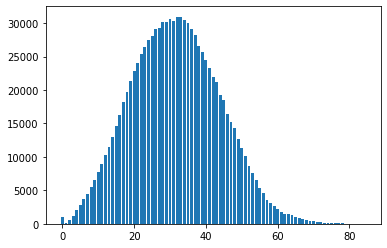

In [8]:
plot_distribution(delta_train_train_emd, 85)

# train vs noise (emd_dist)

In [9]:
noise = np.random.random([1000,6])

delta_train_noise_emd = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        delta_train_noise_emd.append(calc_distance_emd_hist(data_alt3_ori[i], noise[j], 3))        

delta_train_noise_emd = np.array(delta_train_noise_emd)
print(delta_train_noise_emd.shape)
print(np.max(delta_train_noise_emd))
print(np.min(delta_train_noise_emd))
print(np.mean(delta_train_noise_emd))
print(np.std(delta_train_noise_emd, 0))

(1000000,)
1.8630555156104838
0.09710461688237951
0.9915690121318147
0.26082199802118644


190


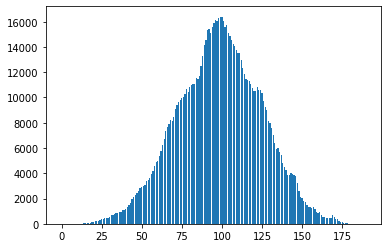

In [10]:
plot_distribution(delta_train_noise_emd, 190)

# train vs gen (emd_dist)

In [11]:
# img_width = 30
# img_height = 24
# img_size = np.math.factorial(6)
# ori_size = np.math.factorial(3)

# data_alt3_gen = pd.read_csv('./generated_results/generated_atl3.csv')
# data_alt3_gen = data_alt3_gen.iloc[:1000,1:].values

# print(data_alt3_gen.shape)

In [12]:
# noise = np.random.random([1000,6])

# delta_train_gen_emd = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         delta_train_gen_emd.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_gen[j], 3))        

# delta_train_gen_emd = np.array(delta_train_gen_emd)
# print(delta_train_gen_emd.shape)
# print(np.max(delta_train_gen_emd))
# print(np.min(delta_train_gen_emd))
# print(np.mean(delta_train_gen_emd))
# print(np.std(delta_train_gen_emd, 0))

In [13]:
# plot_distribution(delta_train_gen_emd, 85)

# train vs gen_1D (emd_dist)

In [14]:
data_alt3_gen_1D = pd.read_csv('gen_alt3_1D.csv')
data_alt3_gen_1D = data_alt3_gen_1D.iloc[:1000,1:].values

print(data_alt3_gen_1D.shape)

(1000, 6)


In [15]:
noise = np.random.random([1000,6])

delta_train_gen_emd = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        delta_train_gen_emd.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_gen_1D[j], 3))        

delta_train_gen_emd = np.array(delta_train_gen_emd)
print(delta_train_gen_emd.shape)
print(np.max(delta_train_gen_emd))
print(np.min(delta_train_gen_emd))
print(np.mean(delta_train_gen_emd))
print(np.std(delta_train_gen_emd, 0))

(1000000,)
0.8415834974821147
0.017109763447384553
0.3096586303629515
0.12163884319091614


85


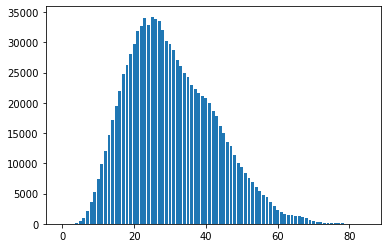

In [16]:
plot_distribution(delta_train_gen_emd, 85)

# train vs gen_1D_condition (emd_dist)

In [17]:
data_alt3_gen_1D_condition = pd.read_csv('gen_alt3_1D_condition.csv')
data_alt3_gen_1D_condition = data_alt3_gen_1D_condition.iloc[:1000,1:].values

print(data_alt3_gen_1D_condition.shape)

(1000, 6)


In [18]:
noise = np.random.random([1000,6])

delta_train_gen_emd = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        delta_train_gen_emd.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_gen_1D_condition[j], 3))        

delta_train_gen_emd = np.array(delta_train_gen_emd)
print(delta_train_gen_emd.shape)
print(np.max(delta_train_gen_emd))
print(np.min(delta_train_gen_emd))
print(np.mean(delta_train_gen_emd))
print(np.std(delta_train_gen_emd, 0))

(1000000,)
0.8107624525099814
0.01036260409008667
0.3150562800034021
0.11116871381039321


85


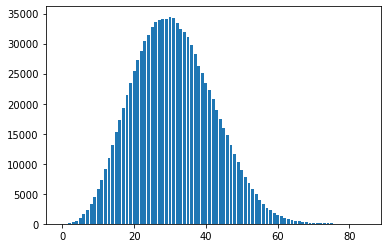

In [19]:
plot_distribution(delta_train_gen_emd, 85)

# ---------------------------------------------------

# train vs train (MAE)

In [20]:
delta_train_train_MAE = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        mse_absolute = np.mean(np.abs(data_alt3_ori[i] - data_alt3_ori[j]))
        delta_train_train_MAE.append(mse_absolute)     
        
delta_train_train_MAE = np.array(delta_train_train_MAE)
print(delta_train_train_MAE.shape)
print(np.max(delta_train_train_MAE))
print(np.min(delta_train_train_MAE))
print(np.mean(delta_train_train_MAE))
print(np.std(delta_train_train_MAE, 0))

(1000000,)
0.33171324422843257
0.0
0.14297275102413615
0.06789898474932772


40


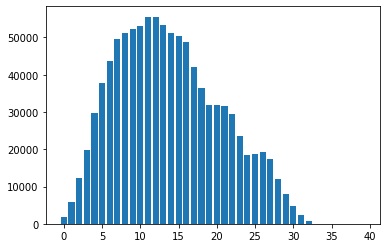

In [21]:
plot_distribution(delta_train_train_MAE, 40)

# train vs noise (MAE)

In [22]:
noise = np.random.random([1000,6])

delta_train_noise_MAE = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        mse_absolute = np.mean(np.abs(data_alt3_ori[i] - noise[j]))
        delta_train_noise_MAE.append(mse_absolute)           
        

delta_train_noise_MAE = np.array(delta_train_noise_MAE)
print(delta_train_noise_MAE.shape)
print(np.max(delta_train_noise_MAE))
print(np.min(delta_train_noise_MAE))
print(np.mean(delta_train_noise_MAE))
print(np.std(delta_train_noise_MAE, 0))

(1000000,)
0.8262596010107005
0.03745617147639265
0.38440554494687224
0.10525770753424145


85


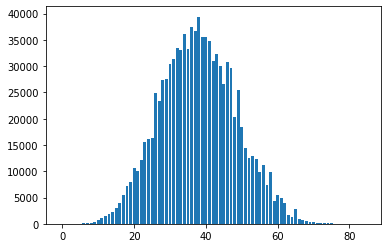

In [23]:
plot_distribution(delta_train_noise_MAE, 85)

# train vs gen (MAE)

In [24]:
# delta_train_gen_MAE = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         mse_absolute = np.mean(np.abs(data_alt3_ori[i] - data_alt3_gen[j]))
#         delta_train_gen_MAE.append(mse_absolute)     
        
# delta_train_gen_MAE = np.array(delta_train_gen_MAE)
# print(delta_train_gen_MAE.shape)
# print(np.max(delta_train_gen_MAE))
# print(np.min(delta_train_gen_MAE))
# print(np.mean(delta_train_gen_MAE))
# print(np.std(delta_train_gen_MAE, 0))

In [25]:
# plot_distribution(delta_train_gen_MAE, 40)

# train vs gen_1D (MAE)

In [26]:
delta_train_gen_MAE = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        mse_absolute = np.mean(np.abs(data_alt3_ori[i] - data_alt3_gen_1D[j]))
        delta_train_gen_MAE.append(mse_absolute)     
        
delta_train_gen_MAE = np.array(delta_train_gen_MAE)
print(delta_train_gen_MAE.shape)
print(np.max(delta_train_gen_MAE))
print(np.min(delta_train_gen_MAE))
print(np.mean(delta_train_gen_MAE))
print(np.std(delta_train_gen_MAE, 0))

(1000000,)
0.3833428410939795
0.008767563701117314
0.12185475920944114
0.05396979186089052


40


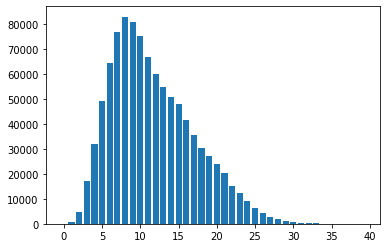

In [27]:
plot_distribution(delta_train_gen_MAE, 40)

# train vs gen_1D_condition (MAE)

In [28]:
delta_train_gen_MAE = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        mse_absolute = np.mean(np.abs(data_alt3_ori[i] - data_alt3_gen_1D_condition[j]))
        delta_train_gen_MAE.append(mse_absolute)     
        
delta_train_gen_MAE = np.array(delta_train_gen_MAE)
print(delta_train_gen_MAE.shape)
print(np.max(delta_train_gen_MAE))
print(np.min(delta_train_gen_MAE))
print(np.mean(delta_train_gen_MAE))
print(np.std(delta_train_gen_MAE, 0))

(1000000,)
0.39773153750000007
0.0036130405492958225
0.13853348576271887
0.06274604385898556


40


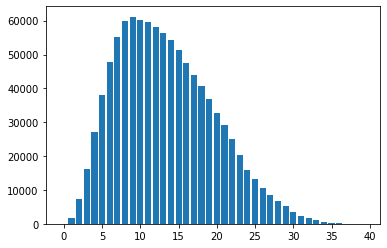

In [29]:
plot_distribution(delta_train_gen_MAE, 40)

In [24]:
# random_num = random.randint(0,len(data_alt3_ori))
delta_train = []
for i in range(len(data_alt3_ori)):
# for i in range(1):
    for j in range(len(data_alt3_ori)):
        mse_absolute = np.mean(np.abs(data_alt3_ori[i] - data_alt3_ori[j]))
        delta_train.append(mse_absolute)     
        
delta_train = np.array(delta_train)
print(delta_train.shape)
print(np.max(delta_train))
print(np.min(delta_train))

(1000000,)
0.33171324422843257
0.0


85


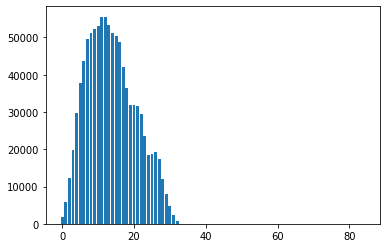

In [25]:
delta_real_sort = np.sort(delta_train)

delta_real_sort_count = []
delta_real_sort_subsample = []
x_axis = []

for i in range(0, 85, 1):
    x_axis.append(i/100)
    iter_ = i/100
    count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
    count_ = np.array(count).reshape([-1]).shape[0]
    delta_real_sort_count.append(count_)
    
delta_real_sort_count = np.array(delta_real_sort_count)
print(len(delta_real_sort_count))

plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)

plt.show()

In [22]:
noise = np.random.random([1000,6])

delta_train_noise = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        delta_train_noise.append(calc_distance_emd_hist(data_alt3_ori[i], noise[j], 3))        

delta_train_noise = np.array(delta_train_noise)
print(delta_train_noise.shape)
print(np.max(delta_train_noise))
print(np.min(delta_train_noise))

(1000000,)
1.8287509075324173
0.07516898882779754


185


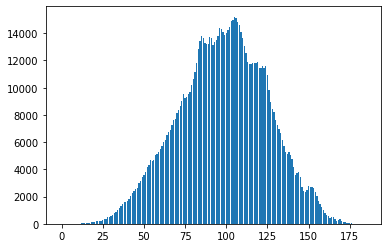

In [23]:
delta_fake_sort = np.sort(delta_train_noise)

delta_fake_sort_count = []
delta_fake_sort_subsample = []

for i in range(0, 185, 1):
    iter_ = i/100
    count = np.where( (iter_ <= delta_fake_sort) & (delta_fake_sort <= (iter_+0.01)))
    count_ = np.array(count).reshape([-1]).shape[0]
    delta_fake_sort_count.append(count_)
    
delta_fake_sort_count = np.array(delta_fake_sort_count)
print(len(delta_fake_sort_count))

plt.bar(range(len(delta_fake_sort_count)), delta_fake_sort_count)
plt.show()

In [28]:
noise = np.random.random([1000,6])

delta_train_noise = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
#         delta_train_noise.append(calc_distance_emd_hist(data_alt3_ori[i], noise[j], 3))   
        mse_absolute = np.mean(np.abs(data_alt3_ori[i] - noise[j]))
        delta_train_noise.append(mse_absolute)           
        

delta_train_noise = np.array(delta_train_noise)
print(delta_train_noise.shape)
print(np.max(delta_train_noise))
print(np.min(delta_train_noise))

(1000000,)
0.8677025653595889
0.03217045829802679


185


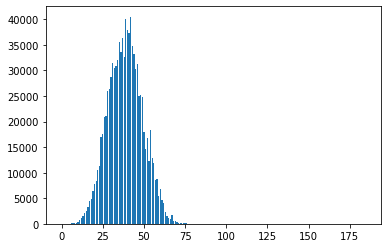

In [29]:
delta_fake_sort = np.sort(delta_train_noise)

delta_fake_sort_count = []
delta_fake_sort_subsample = []

for i in range(0, 185, 1):
    iter_ = i/100
    count = np.where( (iter_ <= delta_fake_sort) & (delta_fake_sort <= (iter_+0.01)))
    count_ = np.array(count).reshape([-1]).shape[0]
    delta_fake_sort_count.append(count_)
    
delta_fake_sort_count = np.array(delta_fake_sort_count)
print(len(delta_fake_sort_count))

plt.bar(range(len(delta_fake_sort_count)), delta_fake_sort_count)
plt.show()

85


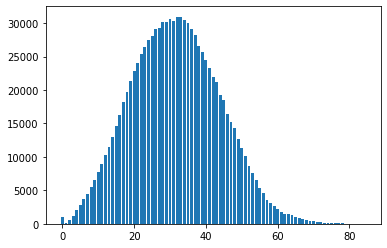

In [7]:
delta_real_sort = np.sort(delta_train)

delta_real_sort_count = []
delta_real_sort_subsample = []
x_axis = []

for i in range(0, 85, 1):
    x_axis.append(i/100)
    iter_ = i/100
    count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
    count_ = np.array(count).reshape([-1]).shape[0]
    delta_real_sort_count.append(count_)
    
delta_real_sort_count = np.array(delta_real_sort_count)
print(len(delta_real_sort_count))

plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)

plt.show()

In [8]:
delta_train_valid = []
for i in range(len(data_alt3_ori)):
    for j in range(len(data_alt3_ori)):
        delta_train_valid.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_val_ori[j], 3))        

delta_train_valid = np.array(delta_train_valid)
print(delta_train_valid.shape)
print(np.max(delta_train_valid))
print(np.min(delta_train_valid))

(1000000,)
0.8359532961939469
0.0039688515341115525


85


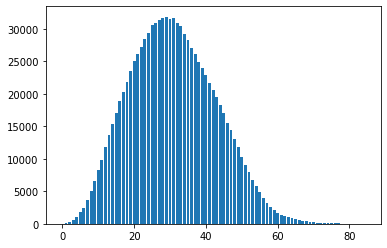

In [9]:
delta_real_sort = np.sort(delta_train_valid)

delta_real_sort_count_valid = []
delta_real_sort_subsample = []

for i in range(0, 85, 1):
    iter_ = i/100
    count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
    count_ = np.array(count).reshape([-1]).shape[0]
    delta_real_sort_count_valid.append(count_)
    
delta_real_sort_count_valid = np.array(delta_real_sort_count_valid)
print(len(delta_real_sort_count_valid))

plt.bar(range(len(delta_real_sort_count_valid)), delta_real_sort_count_valid)
plt.show()

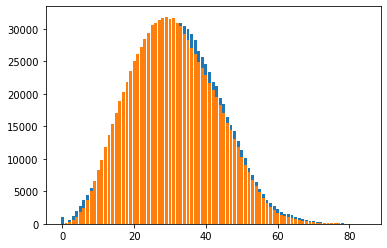

In [10]:
plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)

plt.bar(range(len(delta_real_sort_count_valid)), delta_real_sort_count_valid)
plt.show()

In [11]:
data_alt4_all = pd.read_csv('./data/netflix_data_4alt_resize.csv')
data_alt4 = data_alt4_all.iloc[:1000,1:].values
data_alt4_val = data_alt4_all.iloc[1000:2000,1:].values
data_alt4_rest = data_alt4_all.iloc[2000:,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
data_alt4_val = data_alt4_val.reshape([-1, img_height, img_width])
data_alt4_rest = data_alt4_rest.reshape([-1, img_height, img_width])
print(data_alt4.shape)
print(data_alt4_val.shape)
print(data_alt4_rest.shape)

(1000, 24, 30)
(1000, 24, 30)
(1001, 24, 30)


In [12]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(4)

data_alt4_ori = resize_to_ori_calMRE(data_alt4, img_size, img_width, img_height, ori_size)
data_alt4_val_ori = resize_to_ori_calMRE(data_alt4_val, img_size, img_width, img_height, ori_size)
data_alt4_rest_ori = resize_to_ori_calMRE(data_alt4_rest, img_size, img_width, img_height, ori_size)

print(data_alt4_ori.shape)
print(data_alt4_val_ori.shape)
print(data_alt4_rest_ori.shape)

(1000, 24)
(1000, 24)
(1001, 24)


In [13]:
delta_train = []
for i in range(len(data_alt4_ori)):
    for j in range(len(data_alt4_ori)):
        delta_train.append(calc_distance_emd_hist(data_alt4_ori[i], data_alt4_ori[j], 4))     
        
delta_train = np.array(delta_train)
print(delta_train.shape)
print(np.max(delta_train))
print(np.min(delta_train))

(1000000,)
0.5687332728110107
0.0


85


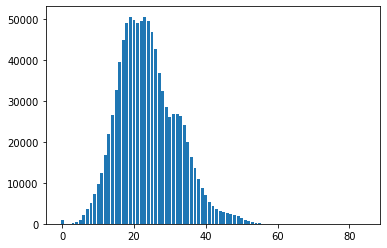

In [14]:
delta_real_sort = np.sort(delta_train)

delta_real_sort_count = []
delta_real_sort_subsample = []
x_axis = []

for i in range(0, 85, 1):
    x_axis.append(i/100)
    iter_ = i/100
    count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
    count_ = np.array(count).reshape([-1]).shape[0]
    delta_real_sort_count.append(count_)
    
delta_real_sort_count = np.array(delta_real_sort_count)
print(len(delta_real_sort_count))

plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)

plt.show()

In [15]:
delta_train_valid = []
for i in range(len(data_alt4_ori)):
    for j in range(len(data_alt4_ori)):
        delta_train_valid.append(calc_distance_emd_hist(data_alt4_ori[i], data_alt4_val_ori[j], 4))        

delta_train_valid = np.array(delta_train_valid)
print(delta_train_valid.shape)
print(np.max(delta_train_valid))
print(np.min(delta_train_valid))

(1000000,)
0.5669854899394573
0.02873370035954605


85


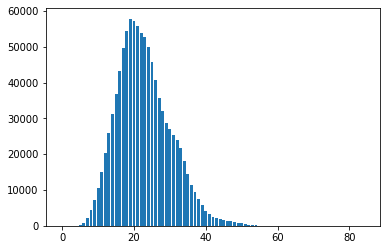

In [16]:
delta_real_sort = np.sort(delta_train_valid)

delta_real_sort_count_valid = []
delta_real_sort_subsample = []

for i in range(0, 85, 1):
    iter_ = i/100
    count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
    count_ = np.array(count).reshape([-1]).shape[0]
    delta_real_sort_count_valid.append(count_)
    
delta_real_sort_count_valid = np.array(delta_real_sort_count_valid)
print(len(delta_real_sort_count_valid))

plt.bar(range(len(delta_real_sort_count_valid)), delta_real_sort_count_valid)
plt.show()

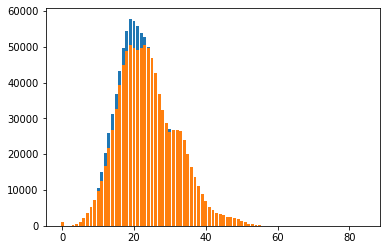

In [18]:
plt.bar(range(len(delta_real_sort_count_valid)), delta_real_sort_count_valid)

plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)

# plt.bar(range(len(delta_real_sort_count_valid)), delta_real_sort_count_valid)
plt.show()

In [10]:
# delta_train = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         delta_train.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_ori[j], 3))        

# delta_train = np.array(delta_train)
# print(delta_train.shape)
# print(np.max(delta_train))
# print(np.min(delta_train))

(1000000,)
0.8409545103246107
0.0


In [11]:
# delta_train_valid = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         delta_train_valid.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_val_ori[j], 3))        

# delta_train_valid = np.array(delta_train_valid)
# print(delta_train_valid.shape)
# print(np.max(delta_train_valid))
# print(np.min(delta_train_valid))

(1000000,)
0.8359532961939469
0.0039688515341115525


In [47]:
# delta_train_rest = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         delta_train_rest.append(calc_distance_emd_hist(data_alt3_ori[i], data_alt3_rest_ori[j], 3))        

# delta_train_rest = np.array(delta_train_rest)
# print(delta_train_rest.shape)
# print(np.max(delta_train_rest))
# print(np.min(delta_train_rest))

(1000000,)
0.8356168464622884
0.00410098772863484


In [12]:
# delta_real = np.concatenate((delta_train, delta_train_valid), axis=0)
# delta_real_mean = np.mean(delta_real)
# delta_real_std = np.std(delta_real, 0)

# print(delta_real.shape)
# print(np.max(delta_real))
# print(np.min(delta_real))
# print(delta_real_mean)
# print(delta_real_std)

(2000000,)
0.8409545103246107
0.0
0.3178369347709569
0.12087203945813023


85


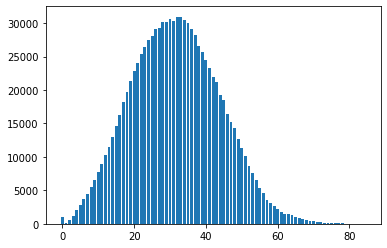

In [131]:
# delta_real_sort = np.sort(delta_train)

# delta_real_sort_count = []
# delta_real_sort_subsample = []
# x_axis = []

# for i in range(0, 85, 1):
#     x_axis.append(i/100)
#     iter_ = i/100
#     count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
#     count_ = np.array(count).reshape([-1]).shape[0]
#     delta_real_sort_count.append(count_)
    
# #     delta_real_sort_subsample.append(delta_real_sort[count[0][0]])

# delta_real_sort_count = np.array(delta_real_sort_count)
# print(len(delta_real_sort_count))

# # delta_real_sort_subsample = np.array(delta_real_sort_subsample)
# # print(len(delta_real_sort_subsample))

# # x_axis = np.array(x_axis)
# # print(x_axis)

# plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)
# # plt.bar(x_axis, delta_real_sort_count)

# plt.show()

In [ ]:
# distance(train1, val1) = 0.1
# distance(train1, val2) = 0.1
# -> val1 == val2 ?

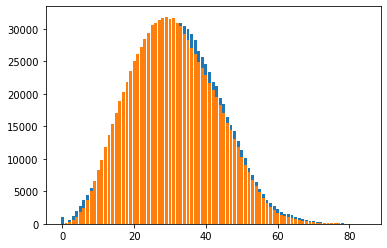

In [138]:
# plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)

# plt.bar(range(len(delta_real_sort_count_valid)), delta_real_sort_count_valid)
# plt.show()

In [ ]:
# MRE_ab - MRE_valid

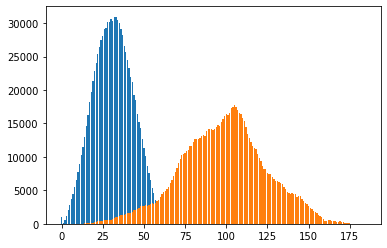

In [132]:
# plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)
# plt.bar(range(len(delta_fake_sort_count)), delta_fake_sort_count)
# plt.show()

85


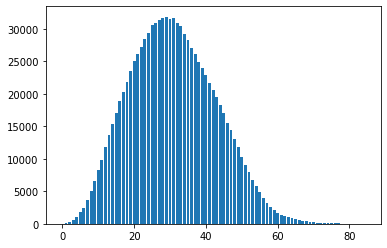

In [137]:
# delta_real_sort = np.sort(delta_train_valid)

# delta_real_sort_count_valid = []
# delta_real_sort_subsample = []

# for i in range(0, 85, 1):
#     iter_ = i/100
#     count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
#     count_ = np.array(count).reshape([-1]).shape[0]
#     delta_real_sort_count_valid.append(count_)
    
# #     delta_real_sort_subsample.append(delta_real_sort[count[0][0]])

# delta_real_sort_count_valid = np.array(delta_real_sort_count_valid)
# print(len(delta_real_sort_count_valid))

# # delta_real_sort_subsample = np.array(delta_real_sort_subsample)
# # print(len(delta_real_sort_subsample))

# plt.bar(range(len(delta_real_sort_count_valid)), delta_real_sort_count_valid)
# plt.show()

In [133]:
# delta_real_sort = np.sort(delta_train_rest)

# delta_real_sort_count = []
# delta_real_sort_subsample = []

# for i in range(0, 85, 1):
#     iter_ = i/100
#     count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
#     count_ = np.array(count).reshape([-1]).shape[0]
#     delta_real_sort_count.append(count_)
    
# #     delta_real_sort_subsample.append(delta_real_sort[count[0][0]])

# delta_real_sort_count = np.array(delta_real_sort_count)
# print(len(delta_real_sort_count))

# # delta_real_sort_subsample = np.array(delta_real_sort_subsample)
# # print(len(delta_real_sort_subsample))

# plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)
# plt.show()

In [134]:
# delta_real_sort = np.sort(delta_real)

# delta_real_sort_count = []
# delta_real_sort_subsample = []

# for i in range(0, 85, 1):
#     iter_ = i/100
#     count = np.where( (iter_ <= delta_real_sort) & (delta_real_sort <= (iter_+0.01)))
#     count_ = np.array(count).reshape([-1]).shape[0]
#     delta_real_sort_count.append(count_)
    
# #     delta_real_sort_subsample.append(delta_real_sort[count[0][0]])

# delta_real_sort_count = np.array(delta_real_sort_count)
# print(len(delta_real_sort_count))

# # delta_real_sort_subsample = np.array(delta_real_sort_subsample)
# # print(len(delta_real_sort_subsample))

# plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)
# plt.show()

In [135]:
# delta_real

array([0.  , 0.35, 0.27, ..., 0.22, 0.1 , 0.09])

In [136]:
# # random_seed = np.random.randint(len(delta_real), size = 100)
# # scipy.stats.ttest_1samp(delta_real[random_seed], 0.3)
# scipy.stats.ttest_1samp(delta_real, 0.9)

Ttest_1sampResult(statistic=-6811.357698808782, pvalue=0.0)

In [105]:
# noise = np.random.random([1000,6])

# delta_train_noise = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         delta_train_noise.append(calc_distance_emd_hist(data_alt3_ori[i], noise[j], 3))        

# delta_train_noise = np.array(delta_train_noise)
# print(delta_train_noise.shape)
# print(np.max(delta_train_noise))
# print(np.min(delta_train_noise))

(1000000,)
1.8341346666711422
0.07373683935075978


In [121]:
# noise = np.random.random([1000,6])

# delta_train_noise = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         delta_train_noise.append(calc_distance_emd_hist(data_alt3_ori[i], noise[j], 3))        

# delta_train_noise = np.array(delta_train_noise)
# print(delta_train_noise.shape)
# print(np.max(delta_train_noise))
# print(np.min(delta_train_noise))

(1000000,)
1.8332653635158493
0.05052824097004493


In [122]:
# noise = np.random.random([1000,6])

# delta_train_noise = []
# for i in range(len(data_alt3_ori)):
#     for j in range(len(data_alt3_ori)):
#         delta_train_noise.append(calc_distance_emd_hist(data_alt3_ori[i], noise[j], 3))        

# delta_train_noise = np.array(delta_train_noise)
# print(delta_train_noise.shape)
# print(np.max(delta_train_noise))
# print(np.min(delta_train_noise))

(1000000,)
1.8435402421586249
0.09304661754641122


185


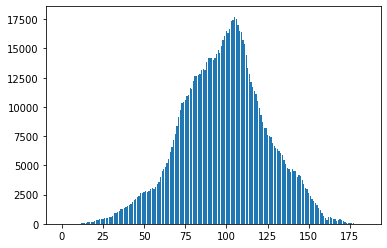

In [128]:
# delta_fake_sort = np.sort(delta_train_noise)

# delta_fake_sort_count = []
# delta_fake_sort_subsample = []

# for i in range(0, 185, 1):
#     iter_ = i/100
#     count = np.where( (iter_ <= delta_fake_sort) & (delta_fake_sort <= (iter_+0.01)))
#     count_ = np.array(count).reshape([-1]).shape[0]
#     delta_fake_sort_count.append(count_)
    
# #     delta_real_sort_subsample.append(delta_real_sort[count[0][0]])

# delta_fake_sort_count = np.array(delta_fake_sort_count)
# print(len(delta_fake_sort_count))

# # delta_real_sort_subsample = np.array(delta_real_sort_subsample)
# # print(len(delta_real_sort_subsample))

# plt.bar(range(len(delta_fake_sort_count)), delta_fake_sort_count)
# plt.show()

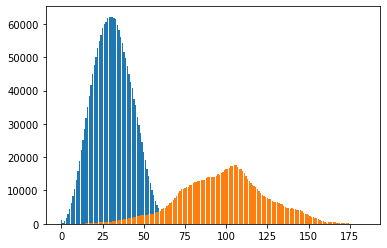

In [130]:
# plt.bar(range(len(delta_real_sort_count)), delta_real_sort_count)
# plt.bar(range(len(delta_fake_sort_count)), delta_fake_sort_count)
# plt.show()